# Surface Reaction

A 1D diffusion model. On the left boundary a surface reaction is modelled.
To handle general surface reactions, we make the concentration at the boundary a variable to be solved.

The governing equation inside the domain is

$$\frac{\partial c}{\partial t} + \mathrm{div} (-D \, \mathrm{grad}(c))  = 0$$

On the boundary we have:

$$D \frac{\partial c}{\partial n} = r(c),$$ 

where $r(c)$ can be a non-linear multicomponentn surface reaction.

## Solution Methodology

The method we use here is to extend the variables to be solved in the system  with the concentratin on the boundary: $c_b$, and then solve the non-linear equation for the surface reaction simultaneous with the other transport equations.

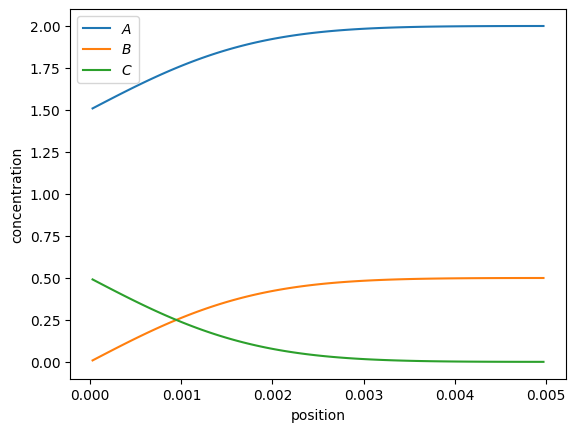

In [39]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output, display
from pymrm import construct_grad, construct_div, update_csc_array_indices, construct_coefficient_matrix, NumJac, newton

L = 0.005
D = 1e-5
num_c = 3
num_x = 100
k = 1.0
dt = 1e-3
num_timesteps = 100
output_interval = 10

def kinetics(c, k):
    rate = np.empty_like(c)
    r = k*c[...,0]*c[...,1]
    rate[...,0] = -r
    rate[...,1] = -r
    rate[...,2] = r
    return rate
    
x_f = np.linspace(0, L, num_x+1)
x_c = 0.5*(x_f[1:] + x_f[:-1])

bc_neumann = {'a': 1, 'b': 0, 'd': 0}
bc_dirichlet = {'a': 0, 'b': 1, 'd': 1}

c_all = np.zeros((num_x+1, num_c))
c_b = c_all[0:1,:]
c = c_all[1:,:]

div_mat = construct_div(c.shape, x_f, axis=0, nu=0)
div_mat = update_csc_array_indices(div_mat, (c.shape, None), (c_all.shape, None), offset = ((1,0), None))

grad_mat, grad_bc_l, grad_bc_r = construct_grad(c.shape, x_f, axis=0, bc = (bc_dirichlet, bc_neumann), shapes_d = ((1, num_c),None))
grad_mat = update_csc_array_indices(grad_mat, (None, c.shape), (None, c_all.shape), offset = (None, (1,0)))

accum_mat = construct_coefficient_matrix(np.asarray(1.0/dt), c.shape)
accum_mat = update_csc_array_indices(accum_mat, c.shape, c_all.shape, offset = (1,0))

jac_cc = accum_mat - D*div_mat@grad_mat
jac_cb = - D*div_mat@grad_bc_l
jac_cb = update_csc_array_indices(jac_cb, (None, c_b.shape), (None, c_all.shape))
jac_bc = D*grad_mat[0:num_c,:]
jac_bc = update_csc_array_indices(jac_bc, (c_b.shape, None), (c_all.shape,None))

jac_const = jac_cc + jac_cb + jac_bc
numjac_b = NumJac(c_b.shape)

def construct_g(c_all, c_old):
    c_b = c_all[0:1,:]
    c_vec = c_all.ravel()
    g_all = np.empty_like(c_all)
    g_vec = g_all.ravel()
    g_b_vec  = g_all[0:1,...].ravel()

    g_vec[...] = jac_const @ c_vec - accum_mat @ c_old.ravel()
    react, jac_react = numjac_b(lambda c_b: kinetics(c_b, k), c_b)
    g_b_vec[...] += D*(grad_bc_l[0:num_c,:] @ c_b.ravel())+ react.ravel()
    jac_bb = D*grad_bc_l[0:num_c,:] + jac_react
    jac_bb = update_csc_array_indices(jac_bb, c_b.shape, c_all.shape)
    jac = jac_const + jac_bb
    return g_vec, jac

c_all[1:,0] = 2.0
c_all[1:,1] = 0.5

labels = [r'$A$',r'$B$',r'$C$']
fig, ax = plt.subplots()
lines = [ax.plot(x_c, c[:, j], label=labels[j])[0] for j in range(num_c)]
ax.set_xlabel('position')
ax.set_ylabel('concentration')
plt.legend()

for i in range(num_timesteps):
    c_old = c_all.copy()
    c_vec = c_all.ravel()
    g_all, jac = construct_g(c_all, c_old)
    result = newton(lambda c_all: construct_g(c_all, c_old), c_all)
    c_all[...] = result.x
    if ((i+1) % output_interval == 0):
        clear_output(wait=True)
        for j in range(num_c):
            lines[j].set_ydata(c[:, j])
        display(fig)
clear_output(wait=True) 